# Пример обучения генеративной сети
https://arxiv.org/abs/1610.09585

In [1]:
# import modules
import keras.backend as K
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

Using TensorFlow backend.


## Загружаем исходные данные

In [2]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.expand_dims(np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28)), axis=1)
test_img = np.expand_dims(np.reshape(test, (len(test), 28, 28)), axis=1)

In [4]:
from sklearn.model_selection import train_test_split
y_train, y_test, X_train, X_test = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

In [5]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

## Визуализируем данные

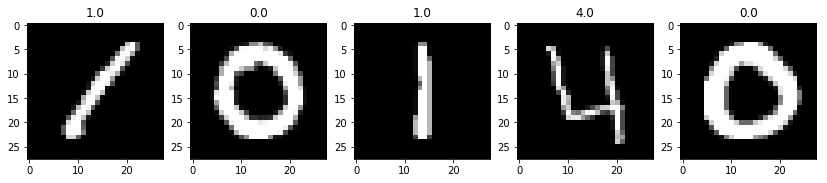

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[0,:,:], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [7]:
LATENT_SIZE = 100

In [8]:
K.set_image_data_format('channels_first')

## Генератор

In [9]:
# generator
cnn = Sequential()

cnn.add(Dense(1024, input_dim=LATENT_SIZE, activation='relu'))
cnn.add(Dense(128 * 7 * 7, activation='relu'))
cnn.add(Reshape((128, 7, 7)))

# upsample to (..., 14, 14)
cnn.add(UpSampling2D(size=(2, 2)))
cnn.add(Conv2D(256, 5, padding='same',
               activation='relu',
               kernel_initializer='glorot_normal'))

# upsample to (..., 28, 28)
cnn.add(UpSampling2D(size=(2, 2)))
cnn.add(Conv2D(128, 5, padding='same',
               activation='relu',
               kernel_initializer='glorot_normal'))

# take a channel axis reduction
cnn.add(Conv2D(1, 2, padding='same',
               activation='tanh',
               kernel_initializer='glorot_normal'))

# this is the z space commonly refered to in GAN papers
latent = Input(shape=(LATENT_SIZE, ))

# this will be our label
image_class = Input(shape=(1,), dtype='int32')

# 10 classes in MNIST
cls = Flatten()(Embedding(10, LATENT_SIZE,
                          embeddings_initializer='glorot_normal')(image_class))

# hadamard product between z-space and a class conditional embedding
h = layers.multiply([latent, cls])

fake_image = cnn(h)

generator = Model([latent, image_class], fake_image)

In [10]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 14, 14)       819456    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 28, 28)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 28, 28)       819328    
__________

In [11]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 100)        1000        input_2[0][0]                    
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 100)           0           embedding_1[0][0]                
___________________________________________________________________________________________

## Дискриминатор

In [12]:
cnn = Sequential()

cnn.add(Conv2D(32, 3, padding='same', strides=2,
               input_shape=(1, 28, 28)))
cnn.add(LeakyReLU())
cnn.add(Dropout(0.3))

cnn.add(Conv2D(64, 3, padding='same', strides=1))
cnn.add(LeakyReLU())
cnn.add(Dropout(0.3))

cnn.add(Conv2D(128, 3, padding='same', strides=2))
cnn.add(LeakyReLU())
cnn.add(Dropout(0.3))

cnn.add(Conv2D(256, 3, padding='same', strides=1))
cnn.add(LeakyReLU())
cnn.add(Dropout(0.3))

cnn.add(Flatten())

image = Input(shape=(1, 28, 28))

features = cnn(image)

# first output (name=generation) is whether or not the discriminator
# thinks the image that is being shown is fake, and the second output
# (name=auxiliary) is the class that the discriminator thinks the image
# belongs to.
fake = Dense(1, activation='sigmoid', name='generation')(features)
aux = Dense(10, activation='softmax', name='auxiliary')(features)

discriminator = Model(image, [fake, aux])

In [13]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 12544)         387840      input_3[0][0]                    
____________________________________________________________________________________________________
generation (Dense)               (None, 1)             12545       sequential_2[1][0]               
____________________________________________________________________________________________________
auxiliary (Dense)                (None, 10)            125450      sequential_2[1][0]               
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 0
___________________

## Задаем параметры обучения

In [14]:
# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                  loss='binary_crossentropy')

## Объединяем генератор и дискриминатор в общую модель

In [15]:
latent = Input(shape=(LATENT_SIZE, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

## Запускаем процесс обучения

In [ ]:
from collections import defaultdict

epochs = 15
batch_size = 100
num_test = X_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

for epoch in range(epochs):
    print('Epoch {} of {}'.format(epoch + 1, epochs))

    num_batches = int(X_train.shape[0] / batch_size)
    progress_bar = Progbar(target=num_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(num_batches):
        progress_bar.update(index)
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, LATENT_SIZE))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, 10, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, LATENT_SIZE))
        sampled_labels = np.random.randint(0, 10, 2 * batch_size)

        # we want to train the generator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels]))

    print('\nTesting for epoch {}:'.format(epoch + 1))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (num_test, LATENT_SIZE))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, 10, num_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * num_test, LATENT_SIZE))
    sampled_labels = np.random.randint(0, 10, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    noise = np.random.uniform(-1, 1, (100, LATENT_SIZE))

    sampled_labels = np.array([
        [i] * 10 for i in range(10)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 28)
                           for r in np.split(generated_images, 10)
                           ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

In [39]:
combined.save_weights('combined.hd5')

In [25]:
noise = np.random.uniform(-1, 1, (100, LATENT_SIZE))

sampled_labels = np.array([[i] * 10 for i in range(10)]).reshape(-1, 1)

generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

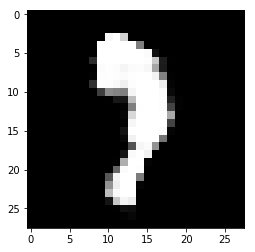

In [38]:
plt.imshow(generated_images[30,0,:,:], cmap='gray')

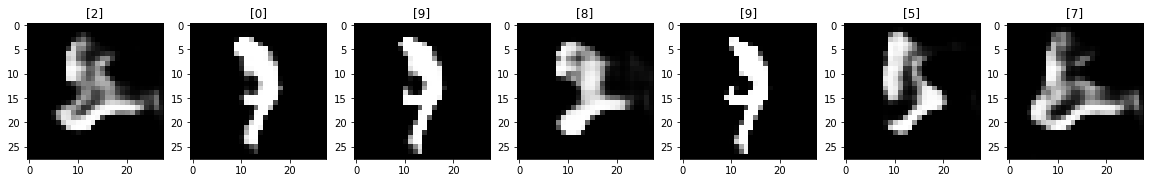

In [30]:
fig = plt.figure(figsize=(20, 10))
sample = np.random.choice(len(generated_images), 7)
for i, img in enumerate(generated_images[sample], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[0,:,:], cmap='gray');
    subplot.set_title('%s' % sampled_labels[sample][i - 1]);